# Instacart Market Basket Analysis

## Data Loading

In [14]:
import modin.pandas as pd

In [15]:
df_orders = pd.read_csv('../data/raw/orders.csv')
df_order_products_train = pd.read_csv('../data/raw/order_products__train.csv')
df_order_products_prior = pd.read_csv('../data/raw/order_products__prior.csv')
df_products = pd.read_csv('../data/raw/products.csv')
df_aisles = pd.read_csv('../data/raw/aisles.csv')
df_departments = pd.read_csv('../data/raw/departments.csv')

As an overview, each data set contains differing information which will help us predict users' orders:

    df_orders: This table includes all orders, divided into a prior, train, and test set. It has a single primary key (order_id).
    df_order_products_train: This table includes only training order data. It has a composite primary key (order_id and product_id) and indicates the target variable for whether a product in an order is a reorder or not (through the reordered variable).
    df_order_products_prior : This table include only prior order data. It has a composite primary key (order_id and product_id) and indicates the target variable forwhether a product in an order is a reorder or not (through the reordered variable).
    df_products: This table includes all products. It has a single primary key (product_id).
    df_aisles: This table includes all aisles. It has a single primary key (aisle_id).
    df_departments: This table includes all departments. It has a single primary key (department_id).

In [16]:
df_aisles['aisle'] = df_aisles['aisle'].astype('category')
df_departments['department'] = df_departments['department'].astype('category')
df_orders['eval_set'] = df_orders['eval_set'].astype('category')
df_products['product_name'] = df_products['product_name'].astype('category')

After converting the above fields to categorical, we can continue with preparing the data frame.

In [17]:
df_orders_products_staging = pd.merge(df_orders, df_order_products_prior, on='order_id', how='inner')

df_orders_products_staging.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


## Feature Engineering

### User Features

In [18]:
user_total_orders = (
    df_orders_products_staging
    .groupby('user_id')['order_number']
    .max()
    .to_frame('user_total_orders')
    .reset_index()
)

user_total_orders.head()

,user_id,user_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


A user's total orders may provide insight into whether the user even will reorder, and the reset index is used to not designate user_id as the index.

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

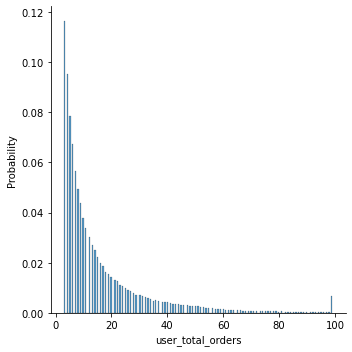

In [20]:
sns.displot(user_total_orders, x='user_total_orders', stat='probability')

The total orders is heavily right skewed as this data set does not include users who have never ordered. To account for this, we can use the log1p function to transform the total orders.

In [21]:
import numpy as np

In [22]:
user_total_orders['user_total_orders_log'] = user_total_orders['user_total_orders'].apply(lambda x: np.log(x + 1))

user_total_orders.head()

,user_id,user_total_orders,user_total_orders_log
0,1,10,2.302585
1,2,14,2.639057
2,3,12,2.484907
3,4,5,1.609438
4,5,4,1.386294


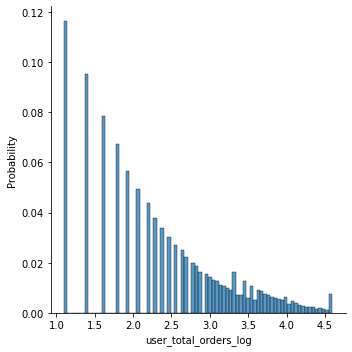

In [23]:
sns.displot(user_total_orders, x='user_total_orders_log', stat='probability')

Since orders is a discrete variable, the distribution remains positively skewed and the logarithmic transformation will have reduced the impact of users with significantly large total orders.

In [24]:
from scipy import stats
  
user_total_orders['user_total_orders_boxcox'], user_total_orders['boxcox_lambda'] = stats.boxcox(user_total_orders['user_total_orders'])

user_total_orders.head()

,user_id,user_total_orders,user_total_orders_log,user_total_orders_boxcox,boxcox_lambda
0,1,10,2.302585,1.744875,-0.253166
1,2,14,2.639057,1.924935,-0.253166
2,3,12,2.484907,1.844344,-0.253166
3,4,5,1.609438,1.321894,-0.253166
4,5,4,1.386294,1.169153,-0.253166


The boxcox transformation can also assit for skewed data.

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

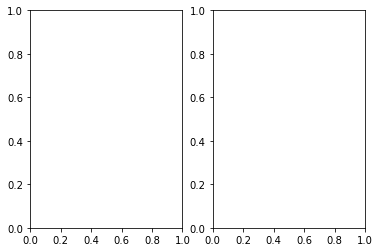

In [25]:
fig, ax = plt.subplots(1, 2)

sns.histplot(
    user_total_orders['user_total_orders']
    , stat = 'percent'
    , label = 'Normal'
    , color ='blue'
    , ax = ax[0]
    )

sns.histplot(
    user_total_orders['user_total_orders_boxcox']
    , stat = 'percent'
    , label = 'Non-Normal'
    , color ='green'
    , ax = ax[1]
    )

plt.legend(loc = "upper right")
  
fig.set_figheight(5)
fig.set_figwidth(10)

### Product Features

In [26]:
product_total_orders = (
    df_orders_products_staging
    .groupby('product_id')['order_id']
    .count()
    .to_frame('product_total_orders')
    .reset_index()
)

product_total_orders.head()

,product_id,product_total_orders
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


Similarly, a product's total orders may provide some insight into whether the product even will be considered to be reordered, and the reset index is used to not designate user_id as the index.

<AxesSubplot:xlabel='product_total_orders', ylabel='Probability'>

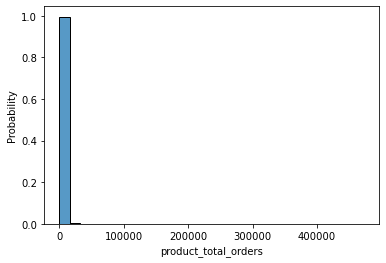

In [27]:
# Note that seaborn auto bins result in an empty plot and the doane binning method is explicitly used.

sns.histplot(
    product_total_orders
    , x='product_total_orders'
    , stat='probability'
    , bins='doane'
    )

In [28]:
product_total_orders['product_total_orders_log'] = product_total_orders['product_total_orders'].apply(lambda x: np.log(x + 1))

product_total_orders.head()

,product_id,product_total_orders,product_total_orders_log
0,1,1852,7.524021
1,2,90,4.499810
2,3,277,5.624018
3,4,329,5.796058
4,5,15,2.708050


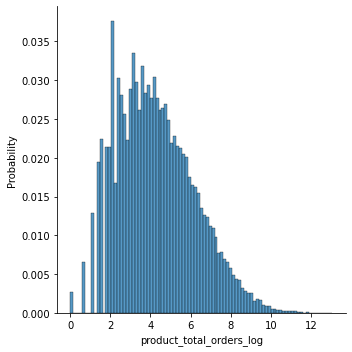

In [29]:
sns.displot(product_total_orders, x='product_total_orders_log', stat='probability')

After the logarithmic transformation, the total orders for a product appears to be approximately normally distributed.

### User-Product Features

In [30]:
user_product_total_orders = (
    df_orders_products_staging
    .groupby(['user_id', 'product_id'])['order_id']
    .count()
    .to_frame('user_product_total_orders')
    .reset_index()
)

user_product_total_orders.head()

,user_id,product_id,user_product_total_orders
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


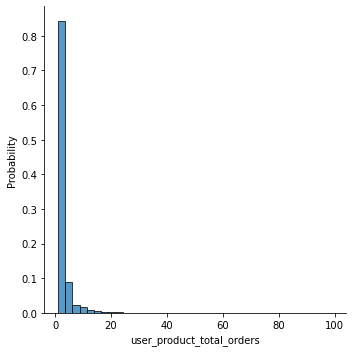

In [31]:
# Note that seaborn auto bins result in an empty plot and the doane binning method is explicitly used.

sns.displot(user_product_total_orders, x='user_product_total_orders', stat='probability', bins='doane')

In [53]:
user_product_total_orders['user_product_total_orders_log'] = user_product_total_orders['user_product_total_orders'].apply(lambda x: np.log(x + 1))

user_product_total_orders.head()

,user_id,product_id,user_product_total_orders,user_product_total_orders_log
0,1,196,10,2.397895
1,1,10258,9,2.302585
2,1,10326,1,0.693147
3,1,12427,10,2.397895
4,1,13032,3,1.386294


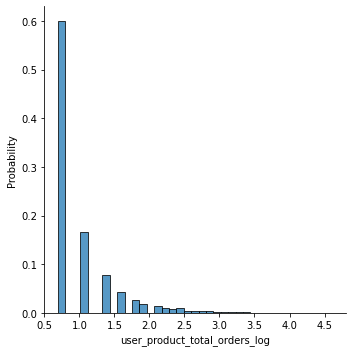

In [54]:
# Note that seaborn auto bins result in an empty plot and the doane binning method is explicitly used.

sns.displot(user_product_total_orders, x='user_product_total_orders_log', stat='probability', bins='doane')

The best indicator may be to simply use the user's existing order history to determine whether the user will reorder a product.  Obviously, this will be helpful for users and products with an existing order history, but it will not be helpful for users and products with no order history.

In [55]:
user_product_total_reorders = (
    df_orders_products_staging
    .groupby(['user_id', 'product_id'])['reordered']
    .sum()
    .to_frame('user_product_total_reorders')
    .reset_index()
)

user_product_total_reorders.head()

,user_id,product_id,user_product_total_reorders
0,1,196,9
1,1,10258,8
2,1,10326,0
3,1,12427,9
4,1,13032,2


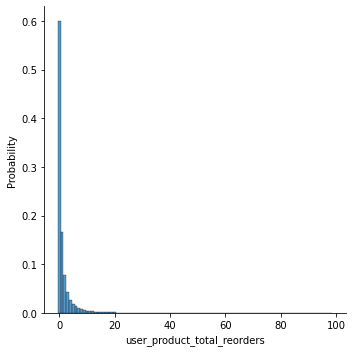

In [56]:
# Note that seaborn auto bins result in an empty plot and the doane binning method is explicitly used.

sns.displot(user_product_total_reorders, x='user_product_total_reorders', stat='probability', discrete=True)

There are enough users that have not reordered a product so this will likely not be useful.  What if we segregate out those that have not reordered?

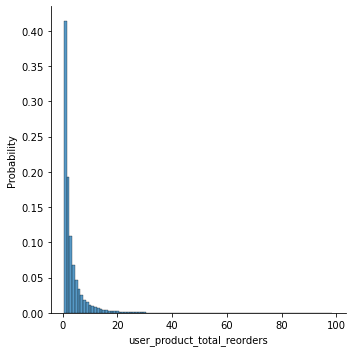

In [57]:
sns.displot(
    user_product_total_reorders[user_product_total_reorders > 0]
    , x='user_product_total_reorders'
    , stat='probability'
    , discrete=True
    )

In [58]:
user_product_total_reorders['user_product_total_reorders_log'] = user_product_total_reorders['user_product_total_reorders'].apply(lambda x: np.log(x + 1))

user_product_total_reorders.head()

,user_id,product_id,user_product_total_reorders,user_product_total_reorders_log
0,1,196,9,2.302585
1,1,10258,8,2.197225
2,1,10326,0,0.000000
3,1,12427,9,2.302585
4,1,13032,2,1.098612


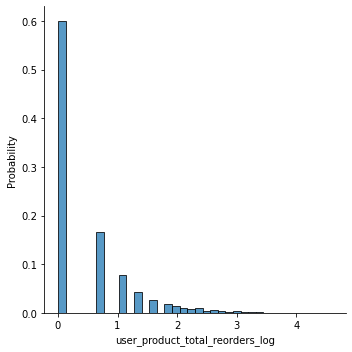

In [59]:
# Note that seaborn auto bins result in an empty plot and the doane binning method is explicitly used.

sns.displot(
    user_product_total_reorders
    , x='user_product_total_reorders_log'
    , stat='probability'
    , bins='doane'
    )

With this we have an idea of how often users order each particular product and need to compile our results into one usable data frame.

### Data Preprocessing

In [60]:
df_staging = pd.merge(user_product_total_orders, user_total_orders, on='user_id', how='left')

df_staging.head()

,user_id,product_id,user_product_total_orders,user_product_total_orders_log,user_total_orders,user_total_orders_log,user_total_orders_boxcox,boxcox_lambda
0,1,196,10,2.397895,10,2.302585,1.744875,-0.253166
1,1,10258,9,2.302585,10,2.302585,1.744875,-0.253166
2,1,10326,1,0.693147,10,2.302585,1.744875,-0.253166
3,1,12427,10,2.397895,10,2.302585,1.744875,-0.253166
4,1,13032,3,1.386294,10,2.302585,1.744875,-0.253166


This brings in the individual user's total order count.

In [61]:
df_staging = pd.merge(df_staging, product_total_orders, on='product_id', how='left')

df_staging.head()

,user_id,product_id,user_product_total_orders,user_product_total_orders_log,user_total_orders,user_total_orders_log,user_total_orders_boxcox,boxcox_lambda,product_total_orders,product_total_orders_log
0,1,196,10,2.397895,10,2.302585,1.744875,-0.253166,35791,10.485452
1,1,10258,9,2.302585,10,2.302585,1.744875,-0.253166,1946,7.573531
2,1,10326,1,0.693147,10,2.302585,1.744875,-0.253166,5526,8.617220
3,1,12427,10,2.397895,10,2.302585,1.744875,-0.253166,6476,8.775858
4,1,13032,3,1.386294,10,2.302585,1.744875,-0.253166,3751,8.229778


This brings in the individual product's total order count.

In [62]:
df_staging = pd.merge(df_staging, user_product_total_reorders, on=['user_id', 'product_id'], how='left')

df_staging.head()

,user_id,product_id,user_product_total_orders,user_product_total_orders_log,user_total_orders,user_total_orders_log,user_total_orders_boxcox,boxcox_lambda,product_total_orders,product_total_orders_log,user_product_total_reorders,user_product_total_reorders_log
0,1,196,10,2.397895,10,2.302585,1.744875,-0.253166,35791,10.485452,9,2.302585
1,1,10258,9,2.302585,10,2.302585,1.744875,-0.253166,1946,7.573531,8,2.197225
2,1,10326,1,0.693147,10,2.302585,1.744875,-0.253166,5526,8.617220,0,0.000000
3,1,12427,10,2.397895,10,2.302585,1.744875,-0.253166,6476,8.775858,9,2.302585
4,1,13032,3,1.386294,10,2.302585,1.744875,-0.253166,3751,8.229778,2,1.098612


This brings in the user product's total reorder count.

## Training Data

In [63]:
df_orders_future = df_orders[((df_orders.eval_set=='train') | (df_orders.eval_set=='test'))]
df_orders_future = df_orders_future[ ['user_id', 'eval_set', 'order_id'] ]

df_orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


Now that we have extracted all the orders that were not prior orders, we have a picture of all the orders that will need to be predicted.  Recall that test orders are orders that will need to be predicted for submission in order to be scored in the Kaggle competition, and are not included in the tradition test segment of a train test split.

In [64]:
df_staging = pd.merge(df_staging, df_orders_future, on='user_id', how='left')
df_staging = df_staging[
    [
        'user_id'
        , 'product_id'
        , 'user_total_orders_boxcox'
        # , 'product_total_orders_log'
        , 'user_product_total_orders_log'
        , 'user_product_total_reorders_log'
        , 'eval_set'
        , 'order_id'
    ]
]

df_staging.head(10)

,user_id,product_id,user_total_orders_boxcox,user_product_total_orders_log,user_product_total_reorders_log,eval_set,order_id
0,1,196,1.744875,2.397895,2.302585,train,1187899
1,1,10258,1.744875,2.302585,2.197225,train,1187899
2,1,10326,1.744875,0.693147,0.000000,train,1187899
3,1,12427,1.744875,2.397895,2.302585,train,1187899
4,1,13032,1.744875,1.386294,1.098612,train,1187899
5,1,13176,1.744875,1.098612,0.693147,train,1187899
6,1,14084,1.744875,0.693147,0.000000,train,1187899
7,1,17122,1.744875,0.693147,0.000000,train,1187899
8,1,25133,1.744875,2.197225,2.079442,train,1187899
9,1,26088,1.744875,1.098612,0.693147,train,1187899


The original fields are dropped in favor of their logarithmic counterparts.

In [65]:
df_train = df_staging[df_staging.eval_set=='train']

df_train.head()

,user_id,product_id,user_total_orders_boxcox,user_product_total_orders_log,user_product_total_reorders_log,eval_set,order_id
0,1,196,1.744875,2.397895,2.302585,train,1187899
1,1,10258,1.744875,2.302585,2.197225,train,1187899
2,1,10326,1.744875,0.693147,0.000000,train,1187899
3,1,12427,1.744875,2.397895,2.302585,train,1187899
4,1,13032,1.744875,1.386294,1.098612,train,1187899


Recall that the target variable for reordered exists in the original training data frame, so that must be joined back.

In [66]:
df_train = pd.merge(
    df_train
    , df_order_products_train[['product_id','order_id', 'reordered']]
    , on=['product_id','order_id']
    , how='left'
    )

df_train.head(10)

,user_id,product_id,user_total_orders_boxcox,user_product_total_orders_log,user_product_total_reorders_log,eval_set,order_id,reordered
0,1,196,1.744875,2.397895,2.302585,train,1187899,1.0
1,1,10258,1.744875,2.302585,2.197225,train,1187899,1.0
2,1,10326,1.744875,0.693147,0.000000,train,1187899,NaN
3,1,12427,1.744875,2.397895,2.302585,train,1187899,NaN
4,1,13032,1.744875,1.386294,1.098612,train,1187899,1.0
5,1,13176,1.744875,1.098612,0.693147,train,1187899,NaN
6,1,14084,1.744875,0.693147,0.000000,train,1187899,NaN
7,1,17122,1.744875,0.693147,0.000000,train,1187899,NaN
8,1,25133,1.744875,2.197225,2.079442,train,1187899,1.0
9,1,26088,1.744875,1.098612,0.693147,train,1187899,1.0


Again, recall that the unique identifier is a composite of the product_id and order_id.  Notice that there are null values for reordered which signify it was not a reorder.

In [67]:
df_train['reordered'] = df_train['reordered'].fillna(0)

df_train.head(10)

,user_id,product_id,user_total_orders_boxcox,user_product_total_orders_log,user_product_total_reorders_log,eval_set,order_id,reordered
0,1,196,1.744875,2.397895,2.302585,train,1187899,1.0
1,1,10258,1.744875,2.302585,2.197225,train,1187899,1.0
2,1,10326,1.744875,0.693147,0.000000,train,1187899,0.0
3,1,12427,1.744875,2.397895,2.302585,train,1187899,0.0
4,1,13032,1.744875,1.386294,1.098612,train,1187899,1.0
5,1,13176,1.744875,1.098612,0.693147,train,1187899,0.0
6,1,14084,1.744875,0.693147,0.000000,train,1187899,0.0
7,1,17122,1.744875,0.693147,0.000000,train,1187899,0.0
8,1,25133,1.744875,2.197225,2.079442,train,1187899,1.0
9,1,26088,1.744875,1.098612,0.693147,train,1187899,1.0


The nulls are reclassified as 0 to register as a correct input in our machine learning model.

In [68]:
df_train = df_train.set_index(['user_id', 'product_id'])

df_train.head(10)

user_total_orders_boxcox  user_product_total_orders_log  \
user_id product_id                                                            
1       196                         1.744875                       2.397895   
        10258                       1.744875                       2.302585   
        10326                       1.744875                       0.693147   
        12427                       1.744875                       2.397895   
        13032                       1.744875                       1.386294   
        13176                       1.744875                       1.098612   
        14084                       1.744875                       0.693147   
        17122                       1.744875                       0.693147   
        25133                       1.744875                       2.197225   
        26088                       1.744875                       1.098612   

                    user_product_total_reorders_log eval_set  order_id  \
user_id product_id                                                       
1       196                                2.302585    train   1187899   
        10258                              2.197225    train   1187899   
        10326                              0.000000    train   1187899   
        12427                              2.302585    train   1187899   
        13032                              1.098612    train   1187899   
        13176                              0.693147    train   1187899   
        14084                              0.000000    train   1187899   
        17122                              0.000000    train   1187899   
        25133                              2.079442    train   1187899   
        26088                              0.693147    train   1187899   

                    reordered  
user_id product_id             
1       196               1.0  
        10258             1.0  
        10326             0.0  
        12427             0.0  
        13032             1.0  
        13176             0.0  
        14084             0.0  
        17122             0.0  
        25133             1.0  
        26088             1.0

User and product IDs are not used as features in the model and only as identifiers, so they are set as indices.

In [69]:
X_non_predictor_variables = ['eval_set', 'order_id']

df_train = df_train.drop(X_non_predictor_variables, axis=1)

df_train.head(10)

user_total_orders_boxcox  user_product_total_orders_log  \
user_id product_id                                                            
1       196                         1.744875                       2.397895   
        10258                       1.744875                       2.302585   
        10326                       1.744875                       0.693147   
        12427                       1.744875                       2.397895   
        13032                       1.744875                       1.386294   
        13176                       1.744875                       1.098612   
        14084                       1.744875                       0.693147   
        17122                       1.744875                       0.693147   
        25133                       1.744875                       2.197225   
        26088                       1.744875                       1.098612   

                    user_product_total_reorders_log  reordered  
user_id product_id                                              
1       196                                2.302585        1.0  
        10258                              2.197225        1.0  
        10326                              0.000000        0.0  
        12427                              2.302585        0.0  
        13032                              1.098612        1.0  
        13176                              0.693147        0.0  
        14084                              0.000000        0.0  
        17122                              0.000000        0.0  
        25133                              2.079442        1.0  
        26088                              0.693147        1.0

The data frame is adjusted to set the user-product ID combination as the index and to remove any fields that will not be used to predict whether a user reorders a product.

## Test Data

In [70]:
from sklearn.model_selection import train_test_split


In [71]:
y_target = 'reordered'

X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(y_target, axis=1)
    , df_train.reordered
    , test_size=0.8
    , random_state=101
    )

## Scaling the Data

In [72]:
from sklearn.preprocessing import StandardScaler

In [73]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Evaluation Data

In [74]:
df_test = df_staging[df_staging.eval_set=='test']

df_test = df_test.set_index(['user_id', 'product_id'])

df_test = df_test.drop(X_non_predictor_variables, axis=1)

df_test.head(10)

user_total_orders_boxcox  user_product_total_orders_log  \
user_id product_id                                                            
3       248                         1.844344                       0.693147   
        1005                        1.844344                       0.693147   
        1819                        1.844344                       1.386294   
        7503                        1.844344                       0.693147   
        8021                        1.844344                       0.693147   
        9387                        1.844344                       1.791759   
        12845                       1.844344                       0.693147   
        14992                       1.844344                       1.098612   
        15143                       1.844344                       0.693147   
        16797                       1.844344                       1.386294   

                    user_product_total_reorders_log  
user_id product_id                                   
3       248                                0.000000  
        1005                               0.000000  
        1819                               1.098612  
        7503                               0.000000  
        8021                               0.000000  
        9387                               1.609438  
        12845                              0.000000  
        14992                              0.693147  
        15143                              0.000000  
        16797                              1.098612

The steps are applied identically to the test data set.

The challenge will be to determine what products will be in the future order based only on the information available in the prior orders.

## Model Building

### Simple Reorder Model

A rudimentary model may be to predict that the user would order the exact same products as their last order. We can use these as baselines to measure our model against.

For exploratory purposes, we can join the product name to provide additional insight.

In [75]:
df_prior_orders_products = pd.merge(df_prior_orders, df_order_products_prior, on='order_id', how='inner')

df_prior_orders_products.head()

NameError: name 'df_prior_orders' is not defined

In [79]:
df_orders_products_staging.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


Now that we have a picture of a user's prior orders, we can begin a rudimentary model to predict that they will order what they did in their most recent order.  Note that this model would not account for users that have not reordered whether they were not satisfied, or are not at the point of doing so.

The challenge is how do we identify their most recent order without a timestamp.  Order number will be our identifier here.

In [84]:
df_most_recent_orders_products = (
    df_orders_products_staging
    .groupby(by=['user_id'])
    .agg({'order_number': 'max'})
)

df_most_recent_orders_products.sort_values('order_number', ascending=False).head()

,order_number
user_id,
152340,99
185641,99
185524,99
81678,99
70922,99


At this point, we can filter the original data for prior orders to only include the most recent order.

In [85]:
df_most_recent_prior_order = pd.merge(
    df_orders_products_staging
    , df_most_recent_orders_products
    , how='inner'
    , on=['user_id', 'order_number']
    )

df_most_recent_prior_order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2550362,1,prior,10,4,8,30.0,196,1,1
1,2550362,1,prior,10,4,8,30.0,46149,2,1
2,2550362,1,prior,10,4,8,30.0,39657,3,0
3,2550362,1,prior,10,4,8,30.0,38928,4,0
4,2550362,1,prior,10,4,8,30.0,25133,5,1


Now we have the 200,000 most recent orders from our users and can presume they will order the exact same basket of goods.  This requires us to understand the structure of our output file.

In [86]:
df_eval_sample = pd.read_csv('../references/sample_submission.csv', low_memory = False)

df_eval_sample.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


Order id is the identifier for the output file, and we will need to construct a new products' field with the concatenation of all the products in the order.

In [108]:
products_reordered = (
    df_most_recent_prior_order
    .groupby(
        df_most_recent_prior_order['user_id'].copy()
        )['user_id','product_id']
    .transform(lambda x: ' '.join(map(str, x)))
)

products_reordered.head()

,user_id,product_id
0,1 1 1 1 1 1 1 1 1,196 46149 39657 38928 25133 10258 35951 13032 ...
1,1 1 1 1 1 1 1 1 1,196 46149 39657 38928 25133 10258 35951 13032 ...
2,1 1 1 1 1 1 1 1 1,196 46149 39657 38928 25133 10258 35951 13032 ...
3,1 1 1 1 1 1 1 1 1,196 46149 39657 38928 25133 10258 35951 13032 ...
4,1 1 1 1 1 1 1 1 1,196 46149 39657 38928 25133 10258 35951 13032 ...


Now that we have structured our products output, we must determine the users that are reordering in our test data set.

In [98]:
df_test_order_products = df_orders.loc[df_orders['eval_set'] == 'test']

df_test_order_products.sort_values(by='order_id').head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611292,17,36855,test,5,6,15,1.0
584613,34,35220,test,20,3,11,8.0
3102779,137,187107,test,9,2,19,30.0
1929637,182,115892,test,28,0,11,8.0
590591,257,35581,test,9,6,23,5.0


In [99]:
df_test_order_products.shape

(75000, 7)

With the test set, we can validate that the 75,000 orders in the test set are included in our rudimentary model.

In [100]:
df_eval_sample_validation = df_test_order_products[df_test_order_products['order_id'].isin(df_eval_sample['order_id'])]

df_eval_sample_validation.sort_values(by='order_id').head()

2022-01-22 20:32:02,657	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
2022-01-22 20:32:03,015	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
2022-01-22 20:32:03,200	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
2022-01-22 20:32:03,420	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
2022-01-22 20:32:04,010	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
2022-01-22 20:32:04,135	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
2022-01-22 20:32:04,629	WARNING worker.py:1245 -- This wor

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611292,17,36855,test,5,6,15,1.0
584613,34,35220,test,20,3,11,8.0
3102779,137,187107,test,9,2,19,30.0
1929637,182,115892,test,28,0,11,8.0
590591,257,35581,test,9,6,23,5.0


In [101]:
df_eval_sample_validation.shape

(75000, 7)

In [102]:
df_eval_orders = pd.merge(df_test_order_products, products_reordered, on='user_id', how='inner')

df_eval_orders.head()

2022-01-22 20:32:22,349	ERROR worker.py:85 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::apply_func() (pid=35992, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 587, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 609, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 441, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RayTaskError: ray::deploy_ray_func() (pid=35992, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 625, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 629, in ray._raylet.execute_task
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\execution\ray\implementations\pandas_on_ray\partitioning\axis_partition.py", line 211, in deploy_ray_func
    result = func(*args)
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\dataframe\pandas\partitioning\axis_partition.py", line 160, in deploy_axis_func
    result = 

RayTaskError(KeyError): [36mray::apply_func()[39m (pid=35992, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 587, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 609, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 441, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RayTaskError: [36mray::deploy_ray_func()[39m (pid=35992, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 625, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 629, in ray._raylet.execute_task
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\execution\ray\implementations\pandas_on_ray\partitioning\axis_partition.py", line 211, in deploy_ray_func
    result = func(*args)
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\dataframe\pandas\partitioning\axis_partition.py", line 160, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\dataframe\pandas\dataframe\dataframe.py", line 1181, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\storage_formats\pandas\query_compiler.py", line 440, in map_func
    return pandas.merge(left, right, **kwargs)
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py", line 119, in merge
    validate=validate,
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py", line 699, in __init__
    ) = self._get_merge_keys()
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py", line 1096, in _get_merge_keys
    right_keys.append(right._get_label_or_level_values(rk))
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py", line 1779, in _get_label_or_level_values
    raise KeyError(key)
KeyError: 'user_id'

2022-01-22 20:32:22,714	ERROR worker.py:85 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::apply_func() (pid=30620, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 587, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 609, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 441, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RayTaskError: ray::deploy_ray_func() (pid=32304, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 625, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 629, in ray._raylet.execute_task
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\execution\ray\implementations\pandas_on_ray\partitioning\axis_partition.py", line 211, in deploy_ray_func
    result = func(*args)
  File "C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\modin\core\dataframe\pandas\partitioning\axis_partition.py", line 160, in deploy_axis_func
    result = 

### Simple Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
skl_logreg = LogisticRegression(random_state=101)

skl_logreg_model = skl_logreg.fit(X_train, y_train)

The train test split is applied to the train data.

## LightGBM

In [ ]:
from sklearn import metrics

import lightgbm as lgb

### Data Loading

In [ ]:
print('Loading data...')

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
X_train.head()

### Model Parameters

In [ ]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'num_leaves': 1000,
    # 'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

evals_result = {}

### Model Training

In [ ]:
print('Starting training...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                early_stopping_rounds=5,
                evals_result=evals_result,
                verbose_eval=5)

In [ ]:
print('Saving model...')

gbm.save_model('../models/lgbm_binary_model.txt')

In [ ]:
print('Training accuracy {:.4f}'.format(gbm.score(x_train, y_train)))
print('Testing accuracy {:.4f}'.format(gbm.score(x_test, y_test)))

In [ ]:
lgb.plot_importance(gbm)

In [ ]:
lgb.plot_metric(gbm)

In [ ]:
print(metrics.classification_report(y_test,gbm.predict(df_test)))

### Model Predictions

In [ ]:
print('Starting predicting on test set...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

### Evaluation Data

The tables are joined to associate the users with the products.  However, the test orders do not indicate the products they ordered.  It provides only the order number, day of week, hour of day, and days since prior order.

The prior data is joined back to understand what products are in the prior orders.

Now that we have our 75,000 records of test data, we can rework the structure to match the model as the input fields will have to be identical.

In [ ]:
print('Starting predicting on eval set...')
# predict
y_pred = gbm.predict(df_test, num_iteration=gbm.best_iteration)

### Model Evaluation

In [ ]:
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

In [ ]:
gbm_feature_importance_values = gbm.feature_importance()
gbm_feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': gbm_feature_importance_values})
gbm_feature_importances.sort_values(by='importance', ascending=False).head(n=10)

## Model Prediction

### Simple Reorder Model

For a truly simplistic model, we will simply predict that the user will order the same basket of goods as their last order.

In [ ]:
df_submission_reorder = df_eval_orders.rename(columns={'product_id': 'products'})[['order_id', 'products']].sort_values(by='order_id')

df_submission_reorder

In [ ]:
df_submission_reorder.to_csv('../models/submission_reorder.csv', index=False)

Alright so the question now is how could we improve the model?  What if we looked simply at products that were reordered and not the products that were not reordered?  Perhaps those items are more likely to be in the basket of goods that the user will order.  Alternatively, we could look at the products that were not reordered and see if they are more likely to be in the basket of goods that the user will order.  Perhaps these new items are more likely to be in the basket of goods that the user will order next.

Recall that our primary target is the Reordered field.  In reality, an item is either reordered or not reordered.  However, the model must predict the probability of an item being reordered or not reordered.  Thus, the simplest approach is to use a logistic regression model.

### Simple Logistic Regression Model

In [ ]:
y_pred = skl_logreg_model.predict(df_test).astype(int)

y_pred[0:20]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

In [ ]:
df_test['prediction'] = y_pred

df_test.head()

In [ ]:
df_test['prediction'].value_counts()

In [ ]:
df_prediction_skl_logreg = df_test.reset_index()

df_prediction_skl_logreg = df_prediction_skl_logreg[ ['product_id', 'user_id', 'prediction'] ]

df_prediction_skl_logreg.head()

With the predictions for each user-product combination, we will now need to restructure our submission to match the format of the Kaggle competition submission.

In [ ]:
df_orders_test = df_orders.loc[df_orders.eval_set=='test',('user_id', 'order_id')]

df_orders_test.head()

The user ID will be used to join the predictions back to the submission.

In [ ]:
df_prediction_skl_logreg = pd.merge(df_prediction_skl_logreg, df_orders_test, on='user_id', how='left')

df_prediction_skl_logreg.head()

The user ID is not required after the join and the product ID should be classified as an integer.

In [ ]:
df_prediction_skl_logreg = df_prediction_skl_logreg.drop('user_id', axis=1)

df_prediction_skl_logreg['product_id'] = df_prediction_skl_logreg.product_id.astype(int)

df_prediction_skl_logreg.head()

The submission requires that all the products in the order be concatenated together into a single field.

In [ ]:
dict_products = dict()
for row in df_prediction_skl_logreg.itertuples():
    if row.prediction == 1:
        try:
            dict_products[row.order_id] += ' ' + str(row.product_id)
        except:
            dict_products[row.order_id] = str(row.product_id)

for order in df_prediction_skl_logreg.order_id:
    if order not in dict_products:
        dict_products[order] = 'None'

In [ ]:
list(dict_products.items())[:5]

With the dictionary of products completed, we can now construct the submission as a data frame.

In [ ]:
df_submission_skl_logreg = pd.DataFrame.from_dict(dict_products, orient='index')

df_submission_skl_logreg.reset_index(inplace=True)

df_submission_skl_logreg.columns = ['order_id', 'products']

df_submission_skl_logreg.head()

In [ ]:
df_submission_skl_logreg.shape

As required, there are two fields, one for the order ID and one with all the product IDs in the predicted subsequent order for all 75,000 orders.

In [ ]:
df_submission_skl_logreg.to_csv('../models/submission_skl_logreg.csv', index=False)

## LightGBM

In [ ]:
y_pred[0:20]

We will need to define a threshold as the submission is not a probabilistic model and is only interested in whether a product is reordered.

In [ ]:
df_test['prediction'] = y_pred

df_test.head()

In [ ]:
df_prediction_lgbm = df_test.reset_index()

df_prediction_lgbm = df_prediction_lgbm[ ['product_id', 'user_id', 'prediction'] ]

df_prediction_lgbm.head()

In [ ]:
df_orders_test = df_orders.loc[df_orders.eval_set=='test',('user_id', 'order_id')]

df_orders_test.head()

In [ ]:
df_prediction_lgbm = pd.merge(df_prediction_lgbm, df_orders_test, on='user_id', how='left')

df_prediction_lgbm.head()

In [ ]:
df_prediction_lgbm = df_prediction_lgbm.drop('user_id', axis=1)

df_prediction_lgbm['product_id'] = df_prediction_lgbm.product_id.astype(int)

df_prediction_lgbm.head()

In [ ]:
threshold_probability = 0.5
dict_products = dict()

for row in df_prediction_lgbm.itertuples():
    if row.prediction > threshold_probability:
        try:
            dict_products[row.order_id] += ' ' + str(row.product_id)
        except:
            dict_products[row.order_id] = str(row.product_id)

for order in df_prediction_lgbm.order_id:
    if order not in dict_products:
        dict_products[order] = 'None'

In [ ]:
list(dict_products.items())[:5]

In [ ]:
df_submission_lgbm = pd.DataFrame.from_dict(dict_products, orient='index')

df_submission_lgbm.reset_index(inplace=True)

df_submission_lgbm.columns = ['order_id', 'products']

df_submission_lgbm.head()

In [ ]:
df_submission_lgbm.shape

In [ ]:
df_submission_skl_logreg.to_csv('../models/submission_lgbm.csv', index=False)